In [53]:
#check my folium version
import folium
print(folium.__version__)


0.14.0


In [ ]:
import duckdb
import networkx as nx
import json
import pandas as pd

from pyvis.network import Network
import matplotlib.pyplot as plt

import folium
from shapely import wkt

In [5]:
# name of the JSON column 
X_SHOP_LOCAL_BRANDS_PCT = 'RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT'
LOCATION_NAME = 'LOCATION_NAME'
TOP_CATEGORY = 'TOP_CATEGORY'
RAW_NUM_CUSTOMERS = 'RAW_NUM_CUSTOMERS'

In [17]:
SPEND_PLACES_PATH = 'data/san-diego-county-places-spend.parquet' # added based on joined output

In [12]:
r1 = duckdb.read_parquet(SPEND_PLACES_PATH)
df = r1.to_df()
df.head()

,CITY,LATITUDE,LONGITUDE,PARENT_PLACEKEY,PLACEKEY,POLYGON_WKT,POSTAL_CODE,REGION,SAFEGRAPH_BRAND_IDS,STREET_ADDRESS,...,SPEND_BY_TRANSACTION_INTERMEDIARY,SPEND_DATE_RANGE_END,SPEND_DATE_RANGE_START,SPEND_PCT_CHANGE_VS_PREV_MONTH,SPEND_PCT_CHANGE_VS_PREV_YEAR,SPEND_PER_TRANSACTION_BY_DAY,SPEND_PER_TRANSACTION_PERCENTILES,SUB_CATEGORY,TOP_CATEGORY,TRANSACTION_INTERMEDIARY
0,Fallbrook,33.363182,-117.249713,None,222-222@5z5-sq3-7h5,POLYGON ((-117.24961958701293 33.3632514508898...,92028.0,CA,None,1625 S Mission Rd,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,-65.0,4.0,"[null,null,null,null,null,63.72,null,null,null...","{""25"":37.97,""75"":93.26}",Caterers,Special Food Services,"{""key_value"":[{""key"":""No intermediary"",""value""..."
1,San Diego,32.962082,-117.189917,223-224@5z5-q36-5j9,223-223@5z5-q36-4sq,POLYGON ((-117.18968099635235 32.9621080316114...,92130.0,CA,SG_BRAND_01644e771a1e10f6,5980 Village Way,...,"{""key_value"":[{""key"":""Plastiq"",""value"":34.97}]}",2025-08-01,2025-07-01,NaN,NaN,"[null,null,null,null,null,null,null,null,null,...","{""25"":7.99,""75"":14.99}",Snack and Nonalcoholic Beverage Bars,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""Plastiq"",""value"":3}]}"
2,Poway,32.950256,-117.062976,None,224-222@5z5-pwm-6tv,"POLYGON ((-117.062901490944 32.95036774128007,...",92064.0,CA,None,12906 Pomerado Rd,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,-61.0,-75.0,"[null,27.37,null,null,null,null,20.01,null,2.7...","{""25"":3.96,""75"":23.48}","Beer, Wine, and Liquor Stores","Beer, Wine, and Liquor Stores","{""key_value"":[{""key"":""No intermediary"",""value""..."
3,San Diego,32.979783,-117.082701,224-223@5z5-pwd-2c5,225-222@5z5-pwd-2c5,POLYGON ((-117.08280491270557 32.9798247527082...,92128.0,CA,SG_BRAND_87bd111b6dd52ef32eaf3abf6d509065,11134 Rancho Carmel Dr Ste 104,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,9.0,-43.0,"[17.29,13.01,11.15,37.12,23.6,15.68,13.3,25.27...","{""25"":11.8,""75"":23.6}",Limited-Service Restaurants,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""No intermediary"",""value""..."
4,Fallbrook,33.372348,-117.252617,None,225-222@5z5-sq2-fmk,POLYGON ((-117.25238131748273 33.3721978555450...,92028.0,CA,SG_BRAND_0c9818695d20f06b7c6cd8ccb3bf3905,1101 S Main Ave Ste B,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,92.0,13.0,"[null,null,null,null,null,null,null,null,null,...","{""25"":47.28,""75"":55.26}",Pet and Pet Supplies Stores,Other Miscellaneous Store Retailers,"{""key_value"":[{""key"":""No intermediary"",""value""..."


In [13]:
df['RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT'].head()

0    {"key_value":[{"key":"Albertsons","value":67},...
1    {"key_value":[{"key":"McDonald's","value":34},...
2    {"key_value":[{"key":"Trader Joe's","value":25...
3    {"key_value":[{"key":"Chevron","value":8},{"ke...
4    {"key_value":[{"key":"Albertsons","value":34},...
Name: RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT, dtype: object

In [14]:
def parse_json_to_tuple(json_str: str) -> list[tuple[str, int]]:
    if not json_str:
        return None
    try:
        data_dict = json.loads(json_str)

        # Handle the nested structure
        if isinstance(data_dict, dict) and "key_value" in data_dict:
            return [(item["key"], item["value"]) for item in data_dict["key_value"]]

        # If it's already a flat dict
        elif isinstance(data_dict, dict):
            return [(k, v) for k, v in data_dict.items()]

        # If it's a list of dicts already
        elif isinstance(data_dict, list):
            return [(item["key"], item["value"]) for item in data_dict]

        return None
    except (ValueError, SyntaxError, KeyError, TypeError):
        return None

In [15]:
G = nx.DiGraph()

df['parsed_brands'] = df[X_SHOP_LOCAL_BRANDS_PCT].apply(parse_json_to_tuple)

In [16]:
df['parsed_brands'].head()

0    [(Albertsons, 67), (Domino's Pizza, 17), (Bask...
1              [(McDonald's, 34), (Panda Express, 34)]
2    [(Trader Joe's, 25), (7-Eleven, 25), (Starbuck...
3    [(Chevron, 8), (Barnes and Noble, 3), (Ross St...
4    [(Albertsons, 34), (Starbucks, 34), (Grocery O...
Name: parsed_brands, dtype: object

In [61]:
def add_nodes_and_edges(row):
    location = row[LOCATION_NAME]
    category = row[TOP_CATEGORY]
    raw_num_customers = row[RAW_NUM_CUSTOMERS]
    latitude = row['LATITUDE']
    longitude = row['LONGITUDE']
    
    # add node, with lat/long
    G.add_node(location, 
               label=location, 
               category=category, 
               num_customers=raw_num_customers,
               latitude=latitude,
               longitude=longitude)

    # add edges
    parsed_brands = row['parsed_brands']
    if parsed_brands:
        for brand, pct in parsed_brands:
            weight = pct / 100
            if weight > .01:
                G.add_edge(location, brand, weight=weight)

In [62]:
df.apply(add_nodes_and_edges, axis=1)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 4527
Number of edges: 45689


## Export Graph to GEXF

In [63]:
# export the graph to a GEXF file for visualization in Gephi
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"graph_{timestamp}.gexf"
nx.write_gexf(G, output_file)

In [64]:
print(len(list(G.nodes)))
print(len(list(G.edges)))
#print(len(list(nx.connected_components(G)))) # only works for undirected graphs

4527
45689


## Clustering

In [65]:
clusters = nx.clustering(G)
sorted(clusters.items(), key=lambda item: item[1], reverse=True)

[('Pw Mart', 1.0),
 ('Santanas Mexican Food', 1.0),
 ('Le Macaron', 1.0),
 ('Olive Cafe', 1.0),
 ('El Azteca Taco Shop', 1.0),
 ('Pizza e Birra', 1.0),
 ('Sorrento', 1.0),
 ('J E Export', 1.0),
 ('Samurai Japanese Restaurant', 1.0),
 ('The Olde Gym', 1.0),
 ('Clairemont Auto Care', 1.0),
 ('Sunny Beauty Supply', 1.0),
 ('Honey Haven', 1.0),
 ('Animal Emergency Clinic of San Diego', 1.0),
 ('Holiday Liquor', 1.0),
 ('Pho46 & Banh Mi', 1.0),
 ('El Norte Liquor', 1.0),
 ('SM Automotive', 1.0),
 ('UCSD Recreation', 1.0),
 ('Pure Smoke Shop', 1.0),
 ('Birrieria Guadalajara', 1.0),
 ('Golden Bagel', 1.0),
 ('Adult Depot', 1.0),
 ('Cazadores', 1.0),
 ('Nutrimart Chula Vista', 1.0),
 ('Corner House Cafe & Pizzeria', 1.0),
 ('Mystical Dragon', 1.0),
 ("Frankie's", 1.0),
 ('San Diego Dry Cleaners', 1.0),
 ('Corvette Diner', 1.0),
 ('Pinto Thai Bistro', 1.0),
 ('Canines Unleashed', 1.0),
 ('Ananas', 1.0),
 ('Harley Davidson', 1.0),
 ('Pitchers Sports Bar', 1.0),
 ('Auto Precision', 1.0),
 ('Inkas

## Isolated Nodes

In [66]:
# find isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated_nodes)}")
print("Isolated nodes:", isolated_nodes)


Number of isolated nodes: 842
Isolated nodes: ['Beverage Factory', 'Dulzura Mini Market', 'Deli Mart', 'Wonderland Coin Laundry', "Agrusa's Super Sandwiches", 'Life is Good', "L'Auberge Del Mar", 'Dia Del Cafe', 'Roya', 'Everyday California', 'Pro Flowers', 'Sala Thai Massage', "Bud's Louisiana Cafe", 'Harmony Nail Lounge', 'Nobelrags', 'Rx Smart Gear', 'Da Wash', 'Kay Jewelers Fashion Valley Mall', 'USA Gasoline', 'San Diego Leather', 'Gilmore Orthodontics', 'Taylor Guitars', 'Active & Fit Direct', 'Sciarrino Marble', 'Grande Colonial', 'Aibertos Taco Shop', 'Dalton Toyota National City', 'View', 'Argco', 'Prince Hookah Cafe', 'Honda of Escondido', 'LA Fitness', 'Cake', 'Ryan Bros Coffee', 'Nutritional Focus', "Yesteryear's Comics", 'Eagle Market', 'Master Sports', 'Sunrise Market & Liquor', 'Abs', 'Cali Banh Mi', 'Steele Canyon Park', 'Looks Better On Me', 'Pearl Laundromat', 'Manscaped', 'Pala Rey Ranch', 'Plaza Donuts & Yogurt', 'Courtyard San Diego Airport Liberty Station', 'Bioto

## Degree Analysis

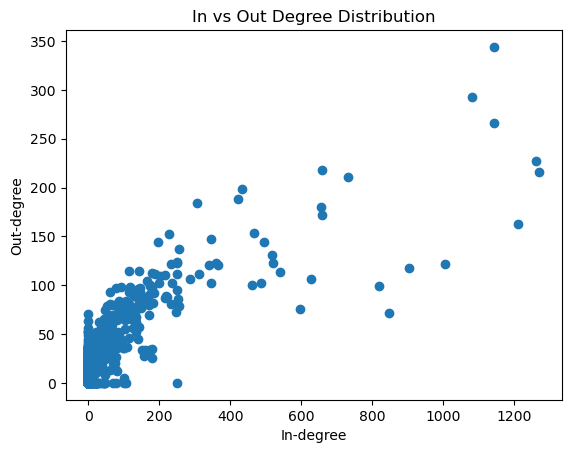

In [67]:
# find most influential nodes using out_degree 
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

plt.scatter(in_degrees.values(), out_degrees.values())
plt.xlabel("In-degree")
plt.ylabel("Out-degree")
plt.title("In vs Out Degree Distribution")
plt.show()

In [71]:
# find the 10 nodes with the most out_degree
top_out_degree = sorted(out_degrees.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 nodes by out-degree:")
for node, degree in top_out_degree:
    print(f"{node}: {degree}")  

# find the 10 nodes with the most in_degree
top_in_degree = sorted(in_degrees.items(), key=lambda item: item[1], reverse=True)[:10]
print("\nTop 10 nodes by in-degree:")
for node, degree in top_in_degree:
    print(f"{node}: {degree}")  

Top 10 nodes by out-degree:
Starbucks: 344
7-Eleven: 293
Chevron: 266
CVS: 227
Panda Express: 218
McDonald's: 216
Jack in the Box: 211
Jersey Mike's: 199
Domino's Pizza: 188
Subway: 184

Top 10 nodes by in-degree:
McDonald's: 1272
CVS: 1263
Vons: 1211
Starbucks: 1145
Chevron: 1143
7-Eleven: 1081
Target: 1006
Ralphs: 905
Walmart: 847
Trader Joe's: 820


## 2nd Degree Neighbors

In [72]:
G.nodes["ALDI"]

{'label': 'ALDI',
 'category': 'Grocery Stores',
 'num_customers': 59.0,
 'latitude': 33.172456,
 'longitude': -117.215178}

In [73]:
node = "ALDI" # node of interest

# First-degree neighbors
first_deg = set(G.neighbors(node))

# Second-degree = neighbors of neighbors, excluding self and first-degree
second_deg = set()
for n in first_deg:
    second_deg.update(G.neighbors(n))
second_deg -= first_deg
second_deg.discard(node)

print(f"Node of interest: {node}")
print("Number of first-degree neighbors:", len(first_deg))
print("First-degree:", first_deg)
print("Number of second-degree neighbors:", len(second_deg))
print("Second-degree:", second_deg)

Node of interest: ALDI
Number of first-degree neighbors: 87
First-degree: {'Cotton On', 'Chipotle Mexican Grill', 'WinCo Foods', 'Albertsons', 'Target', 'Bath & Body Works', 'Stater Bros. Markets', 'BevMo', 'Subway', 'Big 5 Sporting Goods', 'Kaiser Permanente', 'Jack in the Box', 'Shell Oil', 'T.J. Maxx', 'ARCO', 'Taco Bell', 'Courtyard by Marriott', 'Seafood City', 'Best Buy', 'Popeyes Louisiana Kitchen', "Church's Chicken", 'PetSmart', "O'Reilly Auto Parts", 'Burlington', 'Chick-fil-A', 'H&M', 'Dollar Tree', 'Black Angus Steakhouse', 'Dutch Bros Coffee', "Papa John's", 'In-N-Out Burger', 'Walgreens', 'Ross Stores', "Lowe's", 'Smart & Final', 'Grocery Outlet', 'Total Wine & More', 'Burger King', 'HomeGoods', 'AutoZone', 'Walmart', "Soapy Joe's Automatic Car Wash", 'Panda Express', 'Jiffy Lube', 'Sears', 'Tractor Supply Co.', 'Banter by Piercing Pagoda', '7-Eleven', 'Goodwill Industries', 'PostalAnnex+', 'Sprouts', '99 Ranch Market', "Kohl's", "Domino's Pizza", 'Petco', "Dunkin'", "McD

### Include distance as a filter

We will expand this analysis by applying a function that allows filtering based on distance for a given node or location. We use geopy for its accuracy but haversine distance can also be used.

In [20]:
from geopy.distance import great_circle

In [ ]:
# Look at known locations in Encinitas for testing
df[['LATITUDE', 'LONGITUDE', 'LOCATION_NAME', 'POSTAL_CODE']].loc[df['POSTAL_CODE'] == 92024].head(20)

,LATITUDE,LONGITUDE,LOCATION_NAME,POSTAL_CODE
45,33.047815,-117.293617,The Grateful Dog Grooming Shop,92024.0
123,33.044566,-117.293213,Thrifty Threads,92024.0
181,33.048904,-117.261287,Sherwin-Williams,92024.0
266,33.064998,-117.301643,7-Eleven,92024.0
288,33.037075,-117.280158,El Nopalito,92024.0
385,33.066247,-117.266059,LensCrafters,92024.0
405,33.048291,-117.258453,CVS,92024.0
496,33.050216,-117.262134,Five Below,92024.0
555,33.046432,-117.281240,CorePower Yoga,92024.0
584,33.043459,-117.258435,NAPA Auto Parts,92024.0


In [29]:
place_1 = df.iloc[787]
place_2 = df.iloc[288]

print(place_1['LOCATION_NAME'])
print(place_2['LOCATION_NAME'])

Pho-Ever
El Nopalito


In [ ]:
# Get the latitude and longitude for the two locations
place_1_lat_long = (place_1['LATITUDE'], place_1['LONGITUDE'])
place_2_lat_long = (place_2['LATITUDE'], place_2['LONGITUDE'])

# Print the distance between the two locations, this is correct
print(great_circle(place_1_lat_long, place_2_lat_long).miles)

1.3444073195397535


In [ ]:
def get_nodes_within_radius(G, center_node, radius_mi):
    """
    Get all nodes within a given radius (in km) of a center node.
    Uses geodesic distance for accuracy.
    """
    if center_node not in G:
        return []
    
    center_lat = G.nodes[center_node].get('latitude')
    center_lon = G.nodes[center_node].get('longitude')
    
    if center_lat is None or center_lon is None:
        print(f"Warning: {center_node} does not have latitude/longitude data")
        return []
    
    center_point = (center_lat, center_lon)
    nodes_within_radius = []
    
    for node in G.nodes():
        node_lat = G.nodes[node].get('latitude')
        node_lon = G.nodes[node].get('longitude')
        
        if node_lat is None or node_lon is None:
            continue
        
        node_point = (node_lat, node_lon)
        distance = great_circle(center_point, node_point).miles
        
        if distance <= radius_mi:
            nodes_within_radius.append((node, distance))
    
    nodes_within_radius.sort(key=lambda x: x[1])
    return nodes_within_radius

In [74]:
get_nodes_within_radius(G, "Target", 1)

[('Target', 0.0),
 ('Office Depot', 0.04117504157742169),
 ('Nail Palace', 0.04768098459756122),
 ('Super Brows', 0.05878193734734841),
 ('Federico G Drachenberg DDS', 0.0625317386131246),
 ('Donut Bar Eastlake', 0.1516541276129617),
 ('Arya Cleaners', 0.1546208700037268),
 ('Nothing Bundt Cakes', 0.1573616206851758),
 ("Eastlake Lowe's", 0.17570090350173315),
 ('Krispy Kreme Doughnuts', 0.20971839053972885),
 ('Joe & Ernies Pizzeria', 0.2099680739145702),
 ('Pancho', 0.2985754102392335),
 ('Panda Chef', 0.33333906914884276),
 ('VIP Nails and Spa', 0.3465143116164115),
 ('ARYA Cleaners', 0.3577081271085078),
 ('Public Storage', 0.36625761531188017),
 ('Recovery Science', 0.43562147433434545),
 ('Doggie Days', 0.4905454126131186),
 ('Homewood Suites by Hilton', 0.572603416085578),
 ('3N1 Sports Bar & Grill', 0.6807747203405129),
 ('Hot Sauce N More', 0.7455414308369732),
 ('CosmoProf', 0.7863493980940537),
 ('The Search Bar', 0.8397055979025266)]

### Now we will map to show available locations and test distance
This evaluation shows examples of polygons available in our dataset and how down stream analysis can be used by stakeholders to make more accurate decisons with accurate visualizations 

In [48]:
df_enc = df.loc[df['POSTAL_CODE'] == 92024]

In [ ]:
# Convert POLYGON_WKT to geometry
df_enc['geometry'] = df_enc['POLYGON_WKT'].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)

# Create GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(df_enc, geometry='geometry', crs='EPSG:4326')

/var/folders/4k/hqwx1ghj2nz8zjkcpbm8hj900000gn/T/ipykernel_81872/4071013493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enc['geometry'] = df_enc['POLYGON_WKT'].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)


In [ ]:
# Create map, centered on Encinitas for my test
m = folium.Map(location=[33.036986, -117.292447], zoom_start=10)

In [ ]:
# Now I will add polygons to my encinitas map
folium.GeoJson(
    gdf[['LOCATION_NAME', 'TOP_CATEGORY', 'geometry']].head(1000).to_json(), 
    style_function=lambda feature: {
        'fillColor': 'lightblue',
        'color': 'blue',
        'weight': 1,
        'fillOpacity': 0.5,
    },
    tooltip=folium.GeoJsonTooltip(fields=['LOCATION_NAME'], aliases=['Location:']),
    popup=folium.GeoJsonPopup(fields=['LOCATION_NAME', 'TOP_CATEGORY'])
).add_to(m)

# Add a marker for the two locations I used before and draw a line for distance check
folium.Marker(
    location=place_1_lat_long,
    popup=place_1['LOCATION_NAME'],
    tooltip=place_1['LOCATION_NAME']
).add_to(m)

folium.Marker(
    location=place_2_lat_long,
    popup=place_2['LOCATION_NAME'],
    tooltip=place_2['LOCATION_NAME']
).add_to(m)

folium.PolyLine(
    locations=[place_1_lat_long, place_2_lat_long],
    weight=2,
    color='red'
).add_to(m)

m.save('polygon_map.html')
m